In [2]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lightkurve as lk

from StarryStarryProcess import *
from DistributionFunctions import *

starry.config.quiet = True
np.random.seed(1)

In [3]:
def gp_model(array, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
            
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        prot = parameter('star.prot')
        stellar_inc = parameter('star.inc')
        stellar_obl = parameter('star.obl')

        porb = parameter('planet.porb')
        t0 = parameter('planet.t0')
        rp = parameter('planet.r')
        planet_inc = parameter('planet.inc')
        mp = parameter('planet.m')
        ecc = parameter('planet.ecc')
        Omega = parameter('planet.Omega')

        pri_model = starry.Primary(starry.Map(ydeg=15, udeg=2, inc=stellar_inc, obl=stellar_obl), 
            r=parameter('star.r'), 
            m=parameter('star.m'), 
            prot=prot, 
            t0=0.0)
        pri_model.map[1] = parameter('star.u1')
        pri_model.map[2] = parameter('star.u2')

        sec_model = starry.Secondary(starry.Map(0,0), 
            t0=t0, 
            r=rp, 
            m=mp, 
            prot=1,
            porb=porb, 
            ecc=ecc, 
            Omega=Omega, 
            inc=planet_inc)
    
        sys_model = starry.System(pri_model, sec_model)

        # Instantiate the GP
        sp_model = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            r=parameter("gp.r"),
            dr=parameter("gp.dr"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            ydeg=15,
            udeg=2,
            marginalize_over_inclination=False,  
        )

        for n, chunk in enumerate(array):
        
            t = chunk[0]
            flux = chunk[1]
            err = chunk[2]

            ssp_model = StarryStarryProcess(sys_model, sp_model, len(t), 256)

            pm.Potential('marginal_likelihood_'+str(n), ssp_model.marginal_likelihood(t, flux, err))
        
        return model

In [4]:
def bin_out_of_transit(t, flux, err, params, dt=0.06, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

## Get a light curve

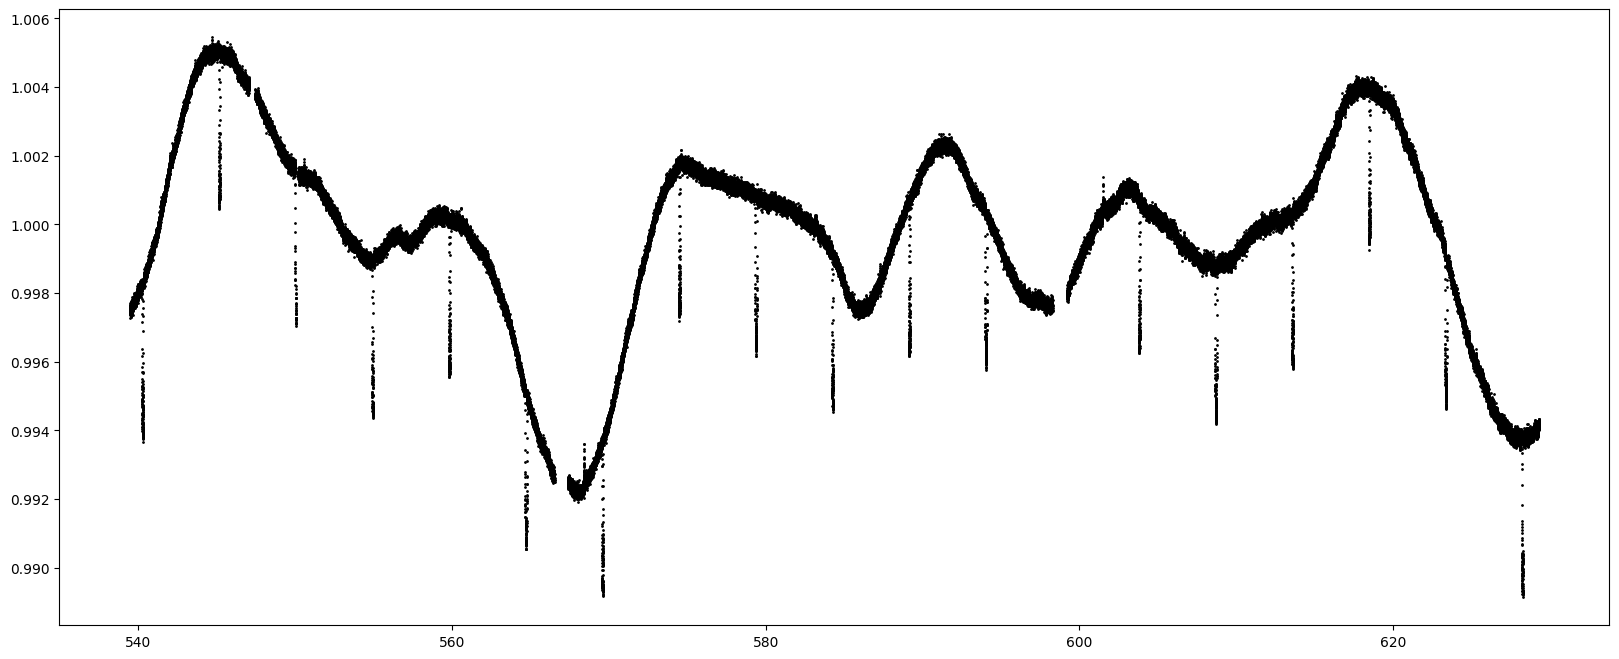

In [5]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short', quarter=6)
# Download all available Kepler light curves
lc_collection_q6 = search_result.download_all()

search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()

all_lc = lc_collection.stitch()
lc_q6 = lc_collection_q6.stitch()

all_lc=all_lc.remove_nans()
lc_q6 = lc_q6.remove_nans()

all_lc = all_lc[all_lc.quality==0]
lc_q6 = lc_q6[lc_q6.quality == 0]

plt.figure(figsize=(20, 8))
plt.plot(lc_q6.time.value, lc_q6.flux, "k.", ms=2)

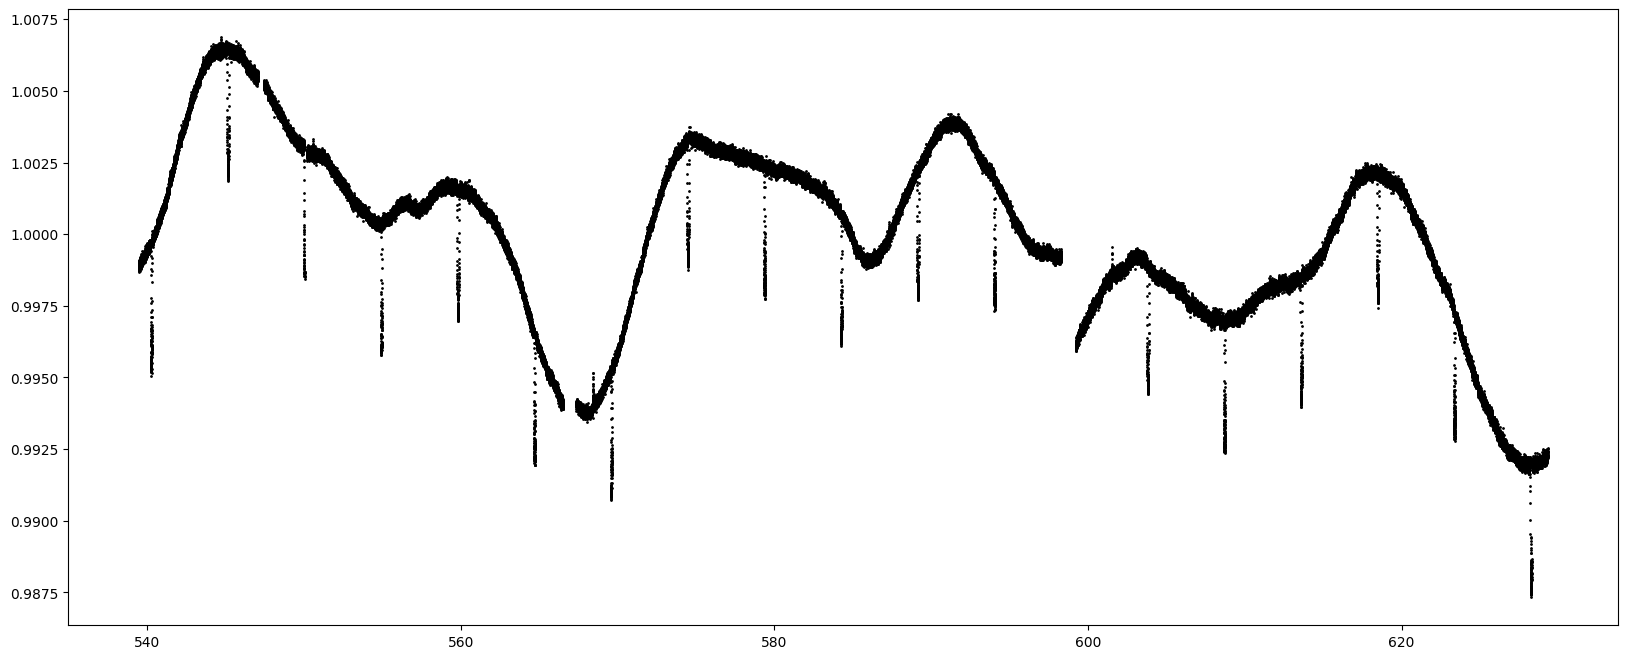

In [6]:
t = lc_q6.time.value #saving the times
flux = np.array(lc_q6.pdcsap_flux.value) # saving the fluxes with PDCSAP
mean_flux = np.mean(np.array(lc_q6.pdcsap_flux.value))
flux_obs = flux / mean_flux

sigma_flux = np.array(lc_q6.pdcsap_flux_err.value) / mean_flux

data = list(zip(t, flux_obs, sigma_flux))

sorted_data = sorted(data, key=lambda x: x[0])

sorted_times, sorted_fluxes, sorted_errors = zip(*sorted_data)

t = np.array(sorted_times)
flux_obs = np.array(sorted_fluxes)
sigma_flux = np.array(sorted_errors)

plt.figure(figsize=(20, 8))
plt.plot(t, flux_obs, "k.", ms=2)

In [7]:
t[0]

539.4599614127364

In [8]:
chunks = []
prot = 30
# Split the times and fluxes into chunks
for start_time in range(int(t[0]), int(t[-1]), prot // 2):
    end_time = start_time + prot // 2
    mask = (t >= start_time) & (t < end_time)
    chunk_times = t[mask]
    chunk_fluxes = flux_obs[mask]
    chunk_sigma_fluxes = sigma_flux[mask]
    chunks.append([chunk_times, chunk_fluxes, chunk_sigma_fluxes])

In [9]:
chunks = np.array(chunks)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_74967/2930193521.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chunks = np.array(chunks)


In [10]:
chunks.shape

(6, 3)

In [11]:
mSun = 1.989e33 # grams
mJ = 1.898e30 
rJ = 6.99e6 # cm
rSun = 69.634e6

mHATP11b = 0.0736 * mJ # grams
mHATP11 = 0.809 * mSun
rHATP11b = 0.389 * rJ # cm
rHATP11 = 0.683 * rSun 

In [12]:
rHATP11 / rSun

0.683

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


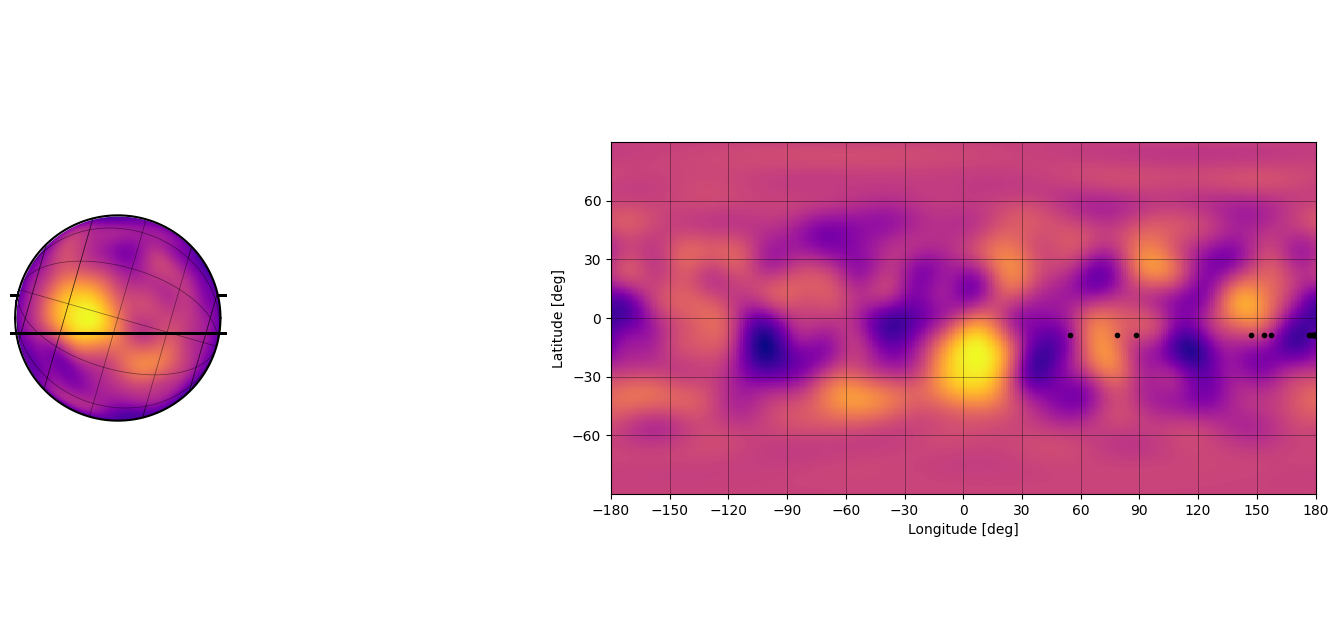

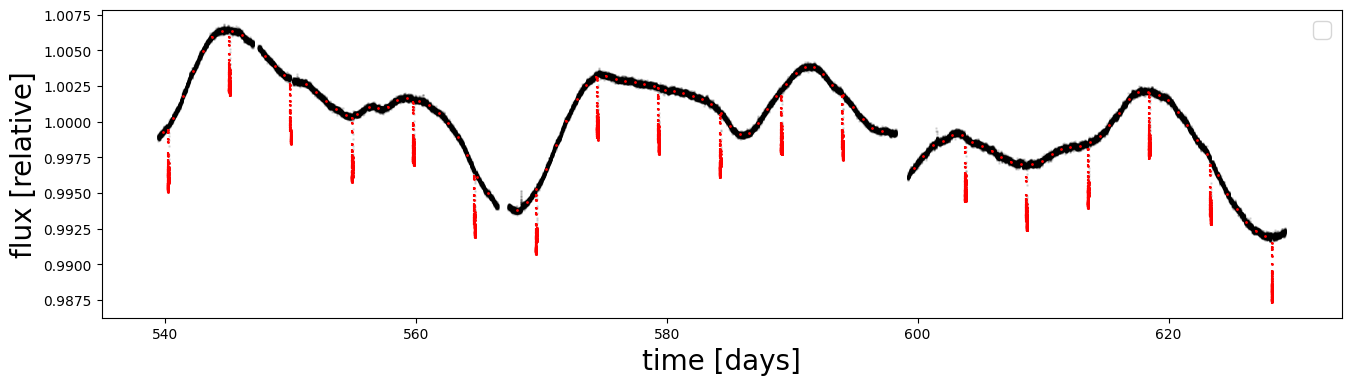

In [13]:
# True parameters & priors
params = {
    "planet.inc": {"truth": 89.05, "dist": Planet_Inc},
    "planet.ecc": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.9]},
    "planet.Omega": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 4.887802443, "dist": Period},
    "planet.t0": {"truth": 124.81, "dist": Uniform, "args": [124.6, 125.1]},
    "planet.r": {"truth": rHATP11b / rSun, "dist": Logarithmic},
    "planet.m": {"truth":  mHATP11b / mSun, "dist": Uniform, "args": [0.00001, 0.0001]},

    "star.inc": {"truth": 90, "dist": Stellar_Ang},
    "star.m": {"truth": mHATP11 / mSun, "dist": Uniform, "args": [0.4, 1]},
    "star.u1": {"truth": 0.646, "dist": Uniform, "args": [0.0, 0.8]},
    "star.u2": {"truth": 0.048, "dist": Uniform, "args": [0.0, 0.1]},
    "star.prot": {"truth": 30, "dist": Uniform, "args": [29.99, 30.05]},
    "star.obl": {"truth": -106.0, "dist": Stellar_Ang},
    "star.r": {"truth": rHATP11 / rSun, "dist": Uniform, "args": [0.1, 1]},

    "gp.r": {"truth": 20, "dist": Uniform, "args": [5.0, 35.0]},
    "gp.dr": {"truth": 5.0, "dist": Uniform, "args": [1.0, 10.0]},
    "gp.c": {"truth": 0.3, "dist": Uniform, "args": [0.1, 0.9]},
    "gp.n": {"truth": 2, "dist": Uniform, "args": [0, 60]},
    "gp.mu": {"truth": 15, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 10, "dist": Uniform, "args": [1.0, 30]}
}

t_, flux_, sigma_flux_ = bin_out_of_transit(t, flux_obs, sigma_flux, params, dt=0.045, binsize=1000)

# Initializing the time
Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = params['star.prot']['truth'] / 20.0

dt = 0.6
idx = np.zeros(len(t_), dtype=bool)
ntransits = int(np.ceil(t_[-1] / params["planet.porb"]["truth"]))
for n in range(ntransits):
    t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
    idx |= ((t_ > t0 - dt) & (t_ < t0 + dt))
t_in = t_[idx]
t_out = t_[~idx]
flux_in = flux_[idx]
flux_out = flux_[~idx]

nt = len(t)

Ttotal = t[-1] - t[0]

# Setting the priors
# fraction bounds for period priors
prot_frac_bounds = min(params['star.prot']['truth']/Ttotal/2, 0.25)
porb_frac_bounds = min(params['planet.porb']['truth']/Ttotal/2, 0.25)

# Let's add this parameter to the parameter dictionary as a prior
params['star.prot']['frac_bounds'] = prot_frac_bounds
params['planet.porb']['frac_bounds'] = porb_frac_bounds

# semi-major axis
a = (params['star.m']['truth']*np.square(params['planet.porb']['truth']/365.25))**(1/3) * 215.03 # Solar radii
# impact parameter
bmax = params['star.r']['truth'] / a

# Let's add this parameter to the parameter dictionary as a prior
params['planet.inc']['bmax'] = bmax

# Plot the data

map = starry.Map(15, 2)
map.inc = params["star.inc"]["truth"]
map.obl = params["star.obl"]["truth"]
map[1] = params["star.u1"]["truth"]
map[2] = params["star.u2"]["truth"]
star = starry.Primary(map, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]["truth"]) 
planet = starry.Secondary(
    starry.Map(0,0),
    inc=params["planet.inc"]["truth"],
    ecc=params["planet.ecc"]["truth"],
    Omega=params["planet.Omega"]["truth"],
    porb=params["planet.porb"]["truth"],
    t0=params["planet.t0"]["truth"],
    r=params["planet.r"]["truth"],
    m=params["planet.m"]["truth"],
)

sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]
theta = (360 * t / params["star.prot"]["truth"]) % 360

# *** Draw 1 sample from the GP
sp = StarryProcess(
    mu=params["gp.mu"]["truth"],
    sigma=params["gp.sigma"]["truth"],
    r=params["gp.r"]["truth"],
    dr=params["gp.dr"]["truth"],
    c=params["gp.c"]["truth"],
    n=params["gp.n"]["truth"],
)

nt = len(t_)
ssp = StarryStarryProcess(sys, sp, len(t), 256)

y_true = sp.sample_ylm().eval().reshape(-1)
y_true[0] += 1

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
map[:, :] = y_true
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
ax[1].plot(lon, lat + mask, "k.");

fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux_obs, 'k.', ms=2, alpha=0.1)
ax.errorbar(t_, flux_, yerr=sigma_flux_, fmt='.', ms=2, color='red')
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [14]:
nt

2096

<ErrorbarContainer object of 3 artists>

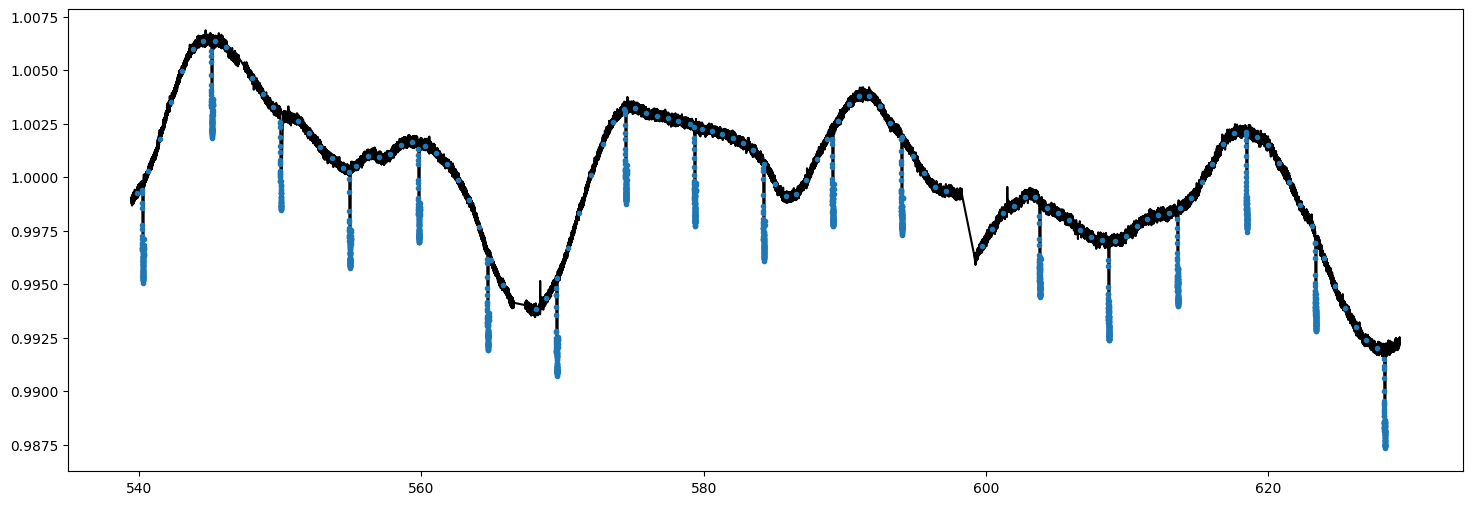

In [15]:
plt.figure(figsize=(18,6))
plt.plot(t, flux_obs, color='k')
plt.errorbar(t_, flux_, yerr=sigma_flux_, fmt='.')

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


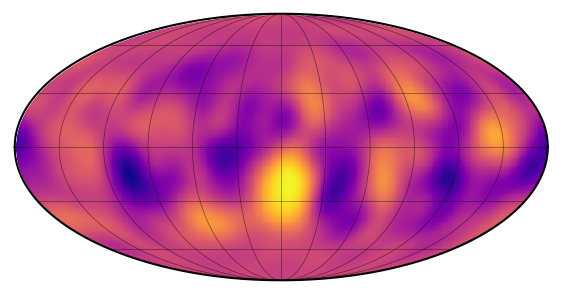

In [17]:
sp.visualize(y_true)

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


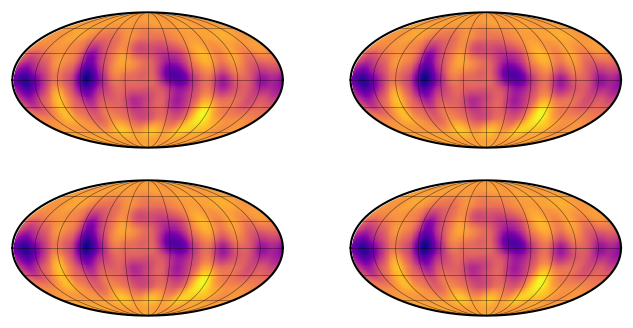

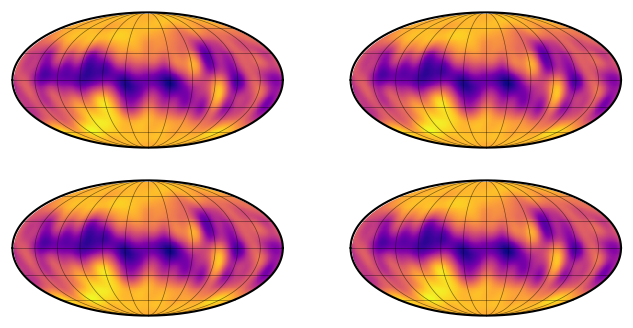

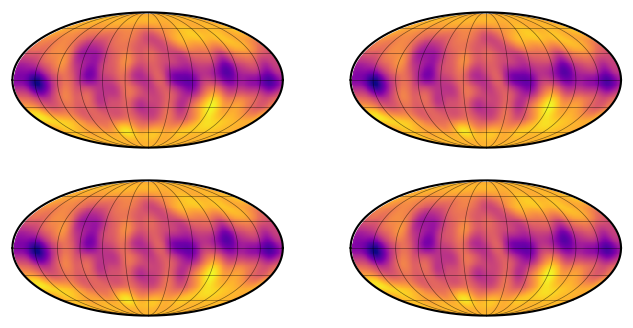

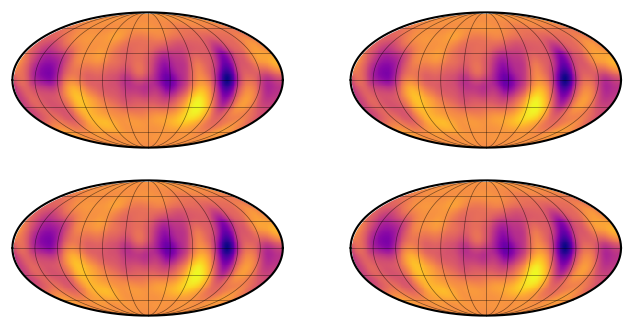

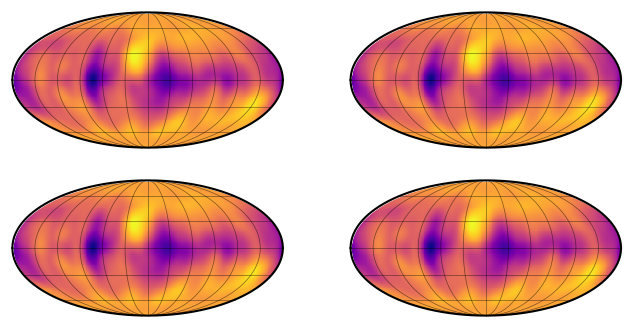

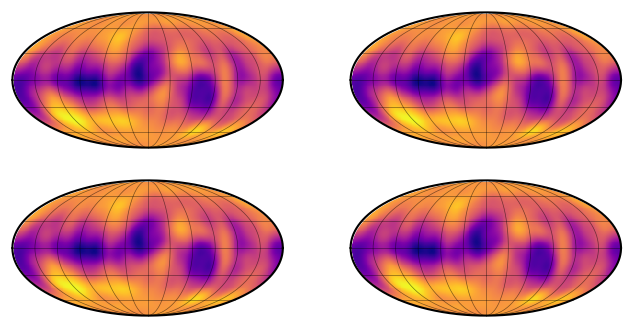

In [18]:
for n, chunk in enumerate(chunks):
    ylm_draw = ssp.sample_ylm_conditional(chunk[0], chunk[1], chunk[2]).eval()[0,:]

    fig, ax = plt.subplots(
    2, 2,
    figsize=(8, 4),
)

    for i in range(2):
        for j in range(2):
            sp.visualize(ylm_draw, ax=ax[i][j])

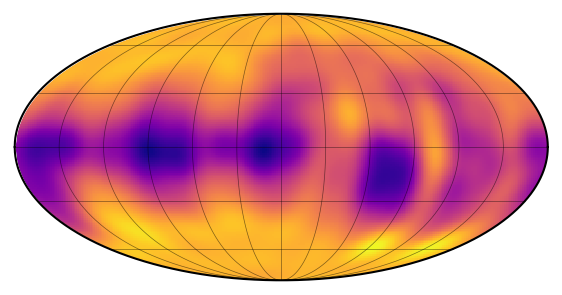

In [19]:
sp.visualize(ssp._a.eval())

In [16]:
chunks_ = []
for i in chunks:
    chunks_bin_time_, chunks_bin_flux_, chunks_bin_mean_ = bin_out_of_transit(i[0], i[1], i[2], params, dt=0.055, binsize=1000)
    chunks_.append([chunks_bin_time_, chunks_bin_flux_, chunks_bin_mean_])

In [17]:
chunks_ = np.array(chunks_)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_74967/1748771126.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chunks_ = np.array(chunks_)


In [18]:
chunks_.shape

(6, 3)

In [19]:
chunks_[0][0].shape

(350,)

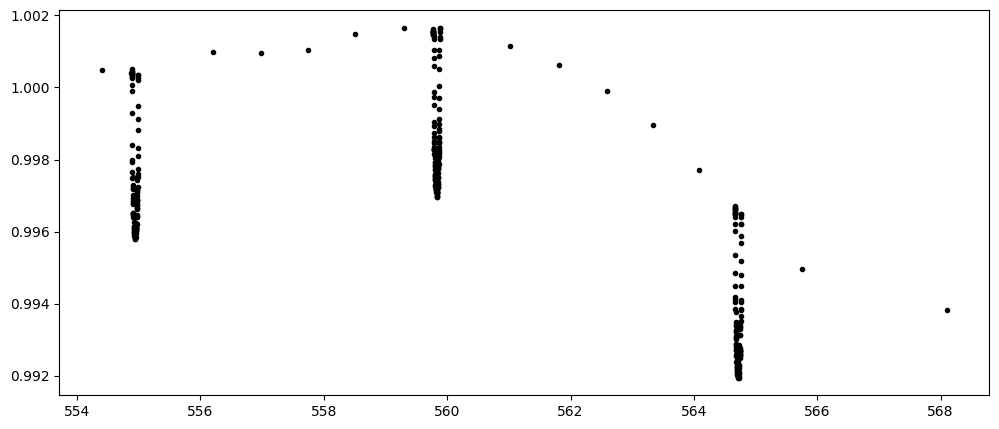

In [20]:
plt.figure(figsize=(12,5))
plt.plot(chunks_[1][0], chunks_[1][1], 'k.')
# plt.xlim(544,546)

In [21]:
chunks_[0][0].shape

(350,)

# Inference

In [31]:
# Set some free params & get the model
p = dict(params)

# p['star.prot']['free'] = True
p['gp.mu']['free'] = True
p['gp.sigma']['free'] = True
p['gp.c']['free'] = True
p['gp.r']['free'] = True

free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(chunks_[:1], p)

In [32]:
free

['gp.r', 'gp.c', 'gp.mu', 'gp.sigma']

In [33]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
optimizing logp for variables: [gp.c, gp.r, gp.sigma, gp.mu]



gp.r: 21.304235442476404 [20]
gp.c: 0.898806643085632 [0.3]
gp.mu: 3.4474543688255945 [15]
gp.sigma: 29.933965755009716 [10]


message: Desired error not necessarily achieved due to precision loss.
logp: -9308.218957680532 -> -7247.034797810987


In [34]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=1,
        cores=4,
        target_accept=0.9,
        return_inferencedata=False,
    )

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
Sequential sampling (1 chains in 1 job)
NUTS: [gp.c, gp.r, gp.sigma, gp.mu]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 29167 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


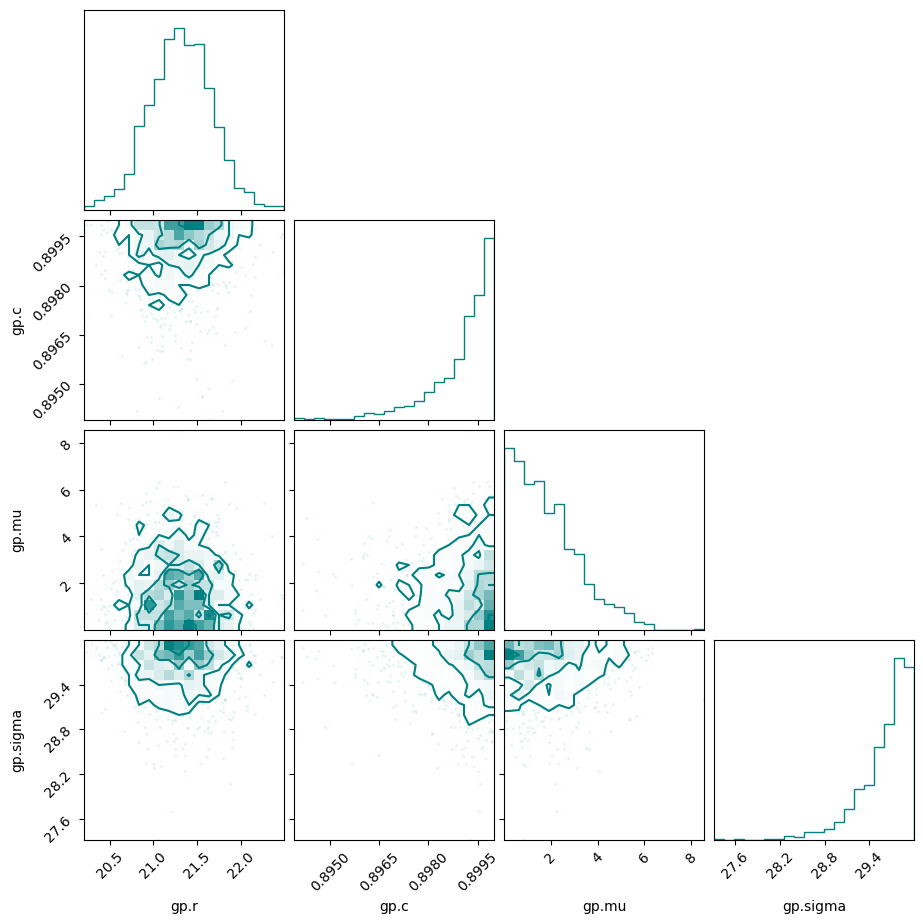

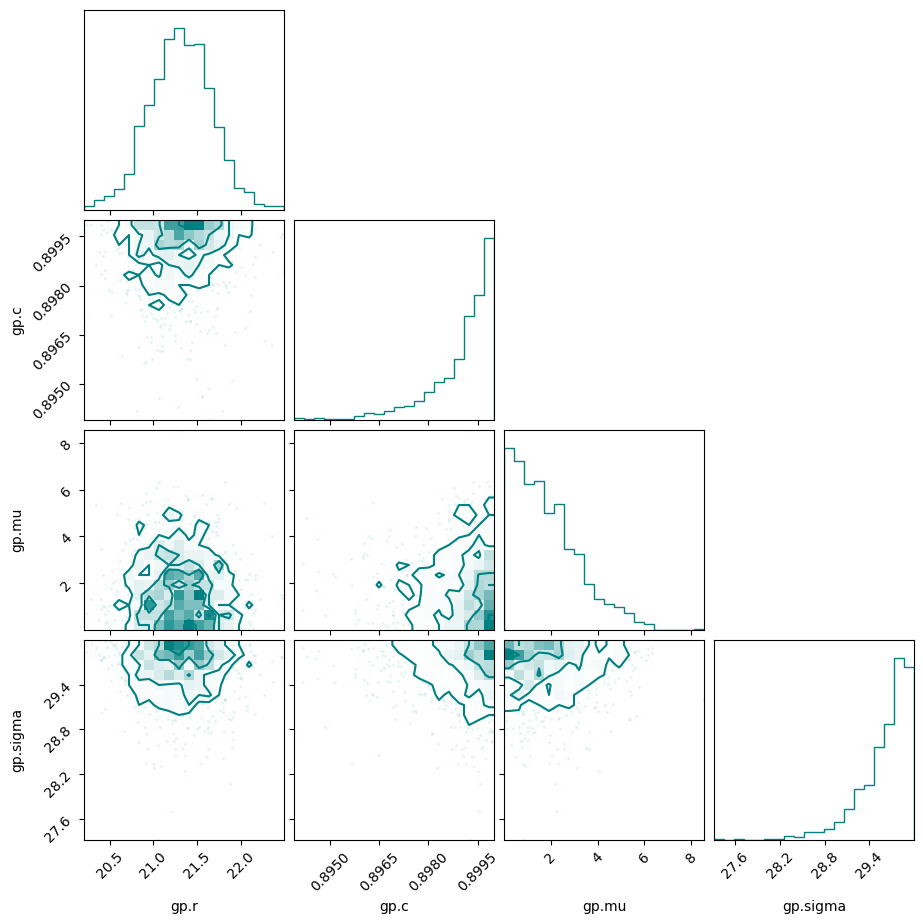

In [35]:
samples = pm.trace_to_dataframe(trace,varnames=free)
corner(np.array(samples),labels=free,truths=[params[x]['truth'] for x in free], color='teal', truth_color='orchid')

### let's save our trace

In [36]:
az.to_netcdf(trace,'SSP-hatp11-chunk1-gps.nc')

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


'SSP-hatp11-chunk1-gps.nc'

In [37]:
# the summary
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gp.mu,1.846,1.375,0.006,4.434,0.053,0.038,456.0,276.0,NaN
gp.sigma,29.610,0.344,29.004,29.999,0.012,0.009,489.0,325.0,NaN
gp.r,21.312,0.357,20.672,21.995,0.020,0.014,328.0,505.0,NaN
gp.c,0.899,0.001,0.897,0.900,0.000,0.000,502.0,355.0,NaN


### now, let's work with the samples from the file

In [22]:
samples_fromfile = az.from_netcdf('SSP-hatp11-chunk1-gps.nc')

In [23]:
samples = samples_fromfile.posterior.to_dataframe()

In [24]:
samples

gp.mu   gp.sigma       gp.r      gp.c
chain draw                                          
0     0     0.394386  29.862075  20.765600  0.898467
      1     0.447537  29.907610  20.645528  0.895862
      2     0.141921  29.733854  20.851083  0.899790
      3     0.359449  29.585366  21.217783  0.899967
      4     3.627696  29.747135  21.599838  0.899944
...              ...        ...        ...       ...
      995   0.024892  29.623139  21.654793  0.898111
      996   0.022411  29.846485  21.090453  0.899751
      997   0.028125  29.855044  21.125784  0.899722
      998   0.086757  29.557191  21.376990  0.899307
      999   0.104021  29.827125  21.115724  0.899439

[1000 rows x 4 columns]

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncSubtensor1{no_inplace,set}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedSubtensor1.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: AdvancedIncS

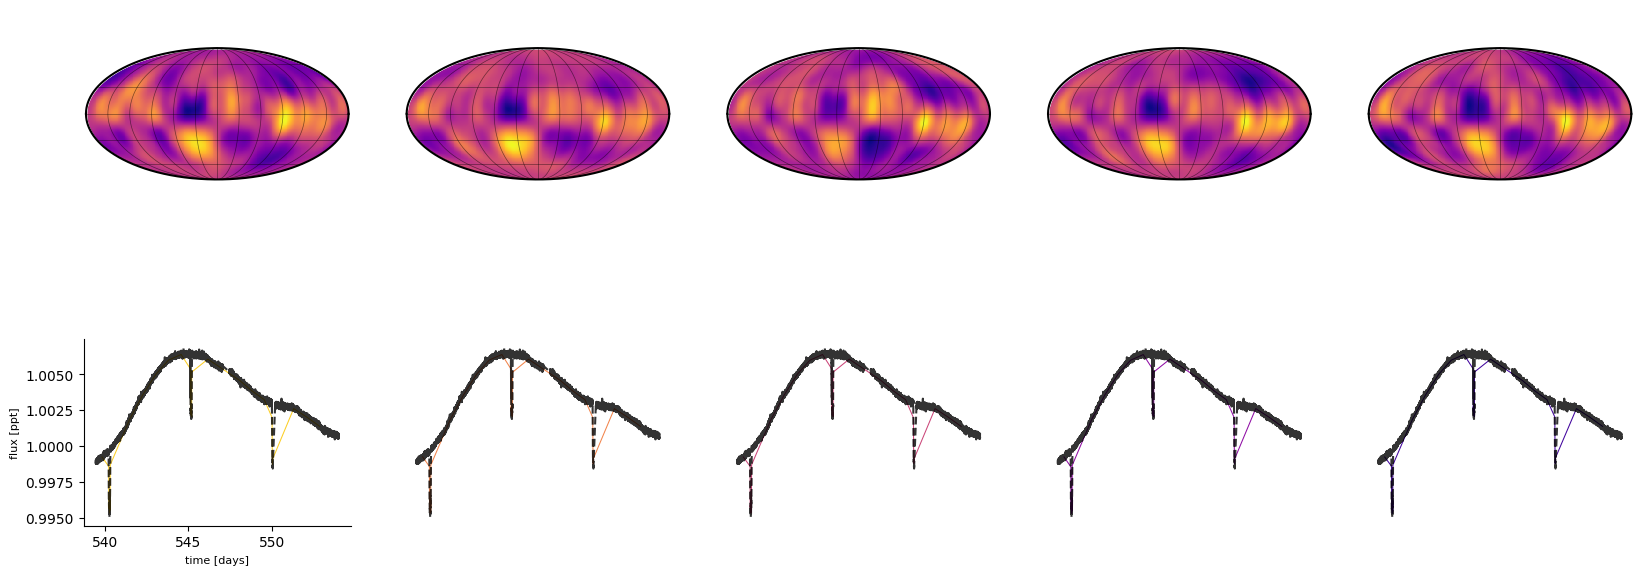

In [52]:
# plotting 5 samples
nsamples = 5
norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (nsamples - 1))


fig, ax = plt.subplots(
    2,
    nsamples,
    figsize=(20, 8),
    gridspec_kw={
        "height_ratios": np.tile([1, 0.5], 1),
        # "width_ratios": np.append(np.ones(nsamples-1), 0.1),
    },
)

for k in range(nsamples):
    # get a random sample from the posterior distributions
    rand_index = np.random.randint(0,samples.shape[0])
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map_samples, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]['truth'], 
                          obl=params["star.obl"]["truth"], inc=params["star.inc"]["truth"]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=params["planet.porb"]['truth'],
        t0=params["planet.t0"]['truth'],
        r=params["planet.r"]['truth'],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    t = chunks_[0][0]
    flux_obs = chunks_[0][1]
    sigma_flux = chunks_[0][2]

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=samples["gp.mu"][0][rand_index],
        sigma=samples["gp.sigma"][0][rand_index],
        r=samples["gp.r"][0][rand_index],
        dr=params["gp.dr"]["truth"],
        c=samples["gp.c"][0][rand_index],
        n=params["gp.n"]['truth'],
    )


    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(ax=ax[0, k], projection="moll")
    ax[0, k].set_ylim(-1.5, 2.25)
    ax[0, k].set_rasterization_zorder(1)
    flux_samples = sys.design_matrix(t).eval()[:, :-1] @ ylm_samples
    ax[1, k].plot(t, flux_samples, color=color(k), lw=0.75, alpha=1)
    ax[1, k].plot(chunks[0][0], chunks[0][1], 'k--', alpha=0.8)

    if k == 0:
        ax[1, k].spines["top"].set_visible(False)
        ax[1, k].spines["right"].set_visible(False)
        ax[1, k].set_xlabel("time [days]", fontsize=8)
        ax[1, k].set_ylabel("flux [ppt]", fontsize=8)
    else:
        ax[1, k].axis("off")


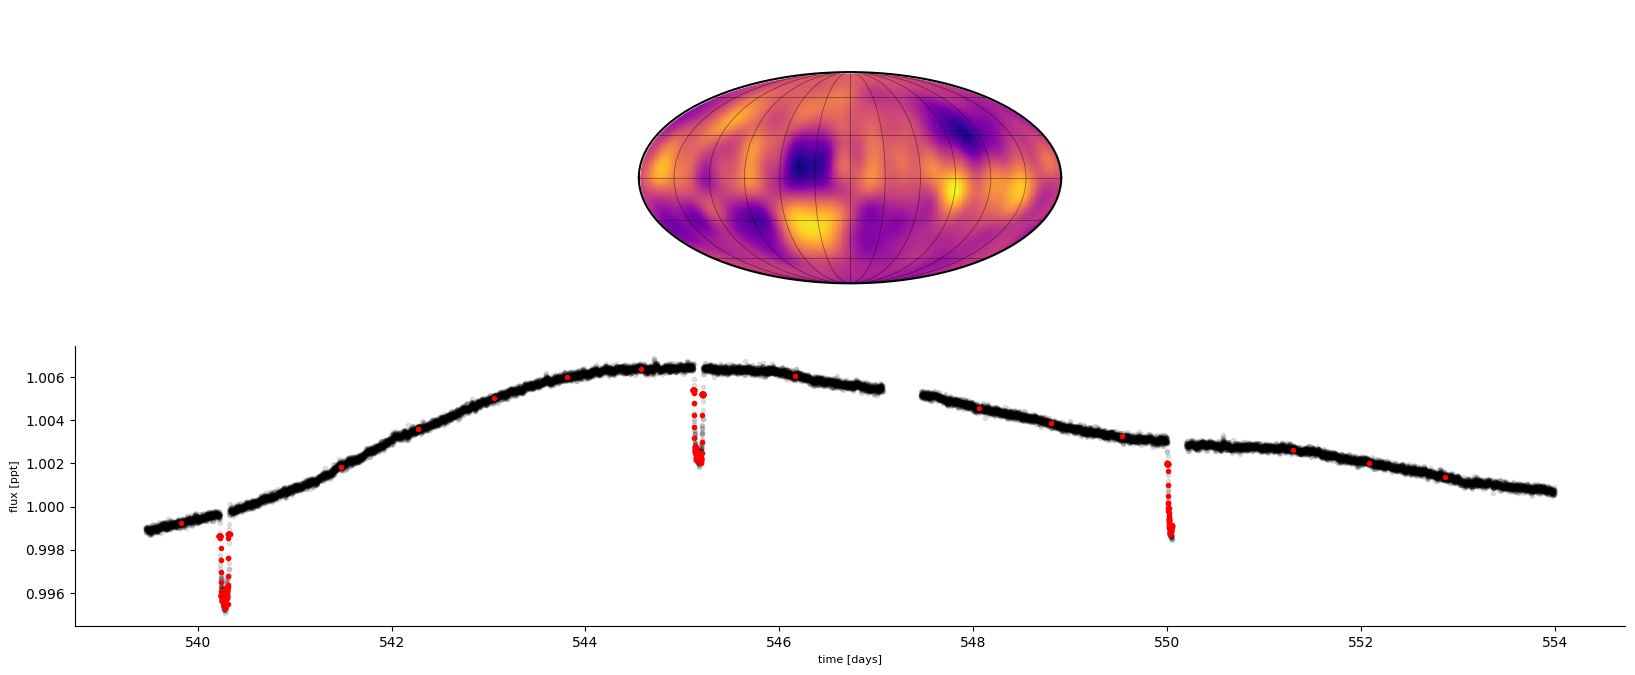

In [26]:
# plotting 5 samples
nsamples = 1
norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (nsamples - 1))


fig, ax = plt.subplots(
    2,
    nsamples,
    figsize=(20, 8),
)

for k in range(nsamples):
    # get a random sample from the posterior distributions
    rand_index = np.random.randint(0,samples.shape[0])
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map_samples, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]['truth'], 
                          obl=params["star.obl"]["truth"], inc=params["star.inc"]["truth"]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=params["planet.porb"]['truth'],
        t0=params["planet.t0"]['truth'],
        r=params["planet.r"]['truth'],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    t = chunks_[0][0]
    flux_obs = chunks_[0][1]
    sigma_flux = chunks_[0][2]

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=samples["gp.mu"][0][rand_index],
        sigma=samples["gp.sigma"][0][rand_index],
        r=samples["gp.r"][0][rand_index],
        dr=params["gp.dr"]["truth"],
        c=samples["gp.c"][0][rand_index],
        n=params["gp.n"]['truth'],
    )


    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(ax=ax[0], projection="moll")
    ax[0].set_ylim(-1.5, 2.25)
    ax[0].set_rasterization_zorder(1)
    flux_samples = sys.design_matrix(t).eval()[:, :-1] @ ylm_samples
    ax[1].plot(chunks[0][0], chunks[0][1], 'k.', alpha=0.1)
    ax[1].plot(t, flux_samples, 'r.', lw=0.75, alpha=1)

    if k == 0:
        ax[1].spines["top"].set_visible(False)
        ax[1].spines["right"].set_visible(False)
        ax[1].set_xlabel("time [days]", fontsize=8)
        ax[1].set_ylabel("flux [ppt]", fontsize=8)
    else:
        ax[1].axis("off")
    
    # plt.xlim(425,430)


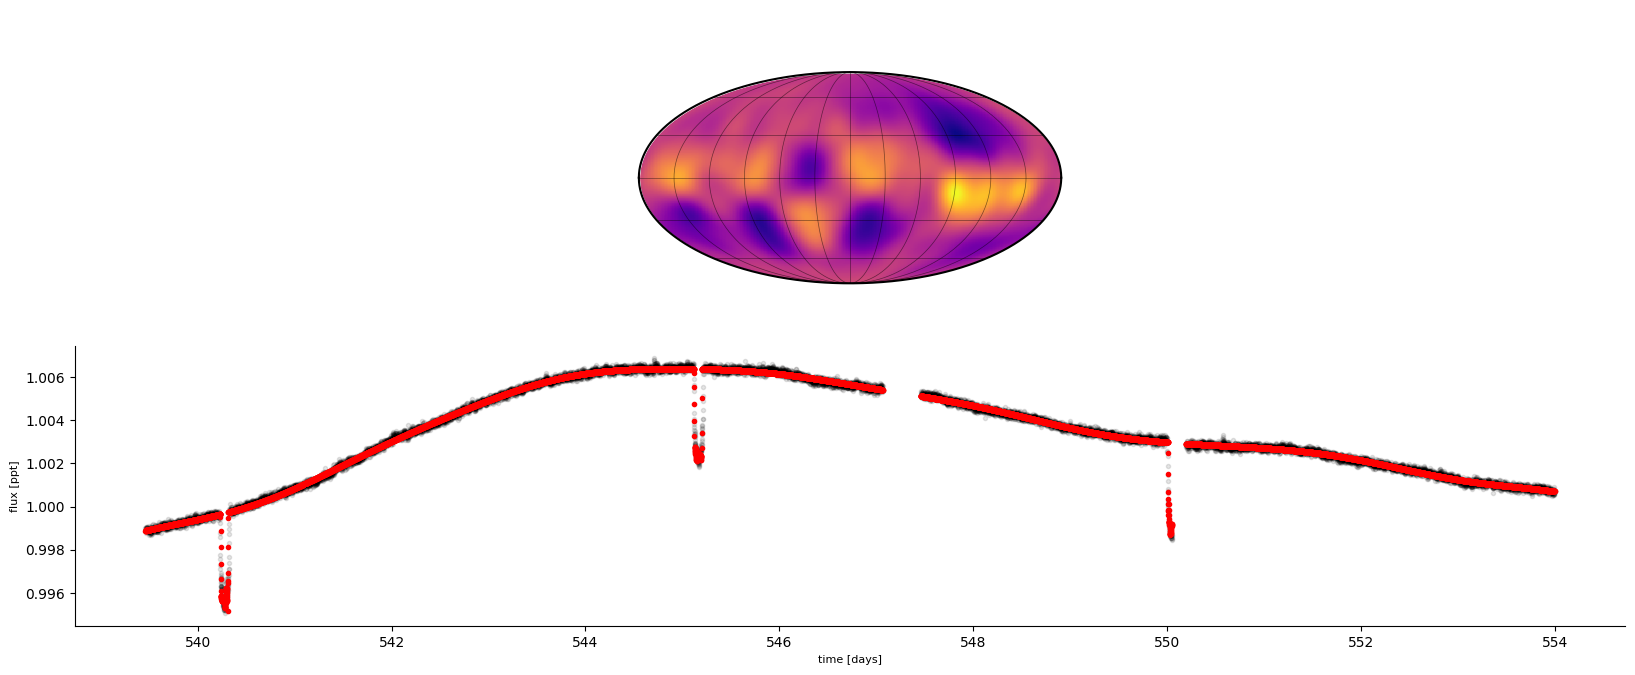

In [27]:
# plotting 5 samples
nsamples = 1
norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (nsamples - 1))


fig, ax = plt.subplots(
    2,
    nsamples,
    figsize=(20, 8),
)

for k in range(nsamples):
    # get a random sample from the posterior distributions
    rand_index = np.random.randint(0,samples.shape[0])
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map_samples, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]['truth'], 
                          obl=params["star.obl"]["truth"], inc=params["star.inc"]["truth"]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=params["planet.porb"]['truth'],
        t0=params["planet.t0"]['truth'],
        r=params["planet.r"]['truth'],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    t = chunks[0][0]
    flux_obs = chunks[0][1]
    sigma_flux = chunks[0][2]

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=samples["gp.mu"][0][rand_index],
        sigma=samples["gp.sigma"][0][rand_index],
        r=samples["gp.r"][0][rand_index],
        dr=params["gp.dr"]["truth"],
        c=samples["gp.c"][0][rand_index],
        n=params["gp.n"]['truth'],
    )


    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(ax=ax[0], projection="moll")
    ax[0].set_ylim(-1.5, 2.25)
    ax[0].set_rasterization_zorder(1)
    flux_samples = sys.design_matrix(t).eval()[:, :-1] @ ylm_samples
    ax[1].plot(chunks[0][0], chunks[0][1], 'k.', alpha=0.1)
    ax[1].plot(t, flux_samples, 'r.', lw=0.75, alpha=1)

    if k == 0:
        ax[1].spines["top"].set_visible(False)
        ax[1].spines["right"].set_visible(False)
        ax[1].set_xlabel("time [days]", fontsize=8)
        ax[1].set_ylabel("flux [ppt]", fontsize=8)
    else:
        ax[1].axis("off")
    
    # plt.xlim(425,430)
